# Restoring Color to Greyscale Images

In [53]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [203]:
import convnets
import train
reload(convnets)
reload(train)

SIZE = 128
IMDIR = "images/raw"

handles = [os.path.join(IMDIR, h) for h in os.listdir(IMDIR)]
print len(handles)

30113


In [204]:
base = convnets.NARROW_COLORIZER_NET
theano_exprs = convnets.CreateTheanoExprs(
    base_net=base,
    height=SIZE,
    width=SIZE,
    learning_rate=0.001)
net, train_fn, val_fn, prediction, target_var, transformed_target = theano_exprs[:6]
convnets.PrintNetworkShape(net)

Net has 8871 parameters.
DimshuffleLayer (None, 3, 128, 128) => (None, 128, 128, 3)
Conv2DLayer (None, 6, 128, 128) => (None, 3, 128, 128)
DropoutLayer (None, 6, 128, 128) => (None, 6, 128, 128)
Conv2DLayer (None, 12, 128, 128) => (None, 6, 128, 128)
Conv2DLayer (None, 24, 128, 128) => (None, 12, 128, 128)
Conv2DLayer (None, 24, 128, 128) => (None, 24, 128, 128)
Conv2DLayer (None, 1, 128, 128) => (None, 24, 128, 128)
DimshuffleLayer (None, 128, 128) => (None, 1, 128, 128)
InputLayer  => (None, 128, 128)


In [205]:
batch_stats, val_stats, err, net  = train.Train(
    num_batches=10,
    validate_every_n_batches=1000000000,
    height=SIZE,
    width=SIZE,
    batch_size=1,
    reps_per_batch=10,
    image_handles=handles[:1],
    val_set_size=0,
    test_set_size=0,
    net=net,
    train_fn=train_fn,
    val_fn=val_fn)

Loading validation and testing images...
Starting training...
Training batch 0 of 10 reps x 1 images. Time = 0.00 seconds. Load time = 0.02 seconds. Error = 1.00000.
Training batch 1 of 10 reps x 1 images. Time = 3.35 seconds. Load time = 0.03 seconds. Error = 0.09299.
Training batch 2 of 10 reps x 1 images. Time = 3.47 seconds. Load time = 0.03 seconds. Error = 0.09293.
Training batch 3 of 10 reps x 1 images. Time = 3.44 seconds. Load time = 0.03 seconds. Error = 0.09289.
Training batch 4 of 10 reps x 1 images. Time = 3.55 seconds. Load time = 0.04 seconds. Error = 0.09279.
Training batch 5 of 10 reps x 1 images. Time = 3.66 seconds. Load time = 0.03 seconds. Error = 0.09272.
Training batch 6 of 10 reps x 1 images. Time = 3.55 seconds. Load time = 0.03 seconds. Error = 0.09263.
Training batch 7 of 10 reps x 1 images. Time = 3.50 seconds. Load time = 0.03 seconds. Error = 0.09246.
Training batch 8 of 10 reps x 1 images. Time = 3.50 seconds. Load time = 0.03 seconds. Error = 0.09239.
Tr

/Users/jeffreyschecter/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [57]:
images = np.zeros((100, SIZE, SIZE, 3))
train.LoadImages(handles, SIZE, SIZE, 100, images)

108

In [58]:
def ImStat(images):
    for i, color in enumerate(["  red", "green", " blue"]):
        channel = images[:, :, :, i]
        print "{c}: mean={m:.2f}, std={s:.2f}".format(
            c=color, m=channel.mean(), s=channel.std())
    grey = (images[:, :, :, 0] * 0.299 +
            images[:, :, :, 1] * 0.587 +
            images[:, :, :, 2] * 0.114)
    print " grey: mean={m:.2f}, std={s:.2f}".format(
        m=grey.mean(), s=grey.std())
    
    sh = images.shape
    rsh = (sh[0], sh[1] * sh[2], sh[3])
    ch = images.reshape(rsh)
    means = ch.mean(axis=1)
    stds = ch.std(axis=1)
    print "Mean of Means:", means.mean(axis=0)
    print " Std of Means:", means.std(axis=0)
    print " Mean of Stds:", stds.mean(axis=0)
    print "  Std of Stds:", stds.std(axis=0)

In [59]:
ImStat(images)

  red: mean=127.27, std=71.09
green: mean=134.70, std=71.08
 blue: mean=146.66, std=75.90
 grey: mean=133.84, std=69.71
Mean of Means: [ 127.26875427  134.69744873  146.66023132]
 Std of Means: [ 41.61128529  42.26608171  46.20481217]
 Mean of Stds: [ 55.72244957  55.03274029  56.92810062]
  Std of Stds: [ 14.75331288  15.39506017  19.63858815]


## Inspecting a Pre-Trained Net

In [136]:
loaded_exprs = convnets.LoadSavedNet(convnets.COLORIZER_NET, 128, 128, "COLORIZER_NET-1446762035.npz")
loaded_net = loaded_exprs[0]

In [137]:
evaluator = convnets.Evaluator(*loaded_exprs[3:])

In [95]:
untrained_exprs = convnets.CreateTheanoExprs(
    base_net=convnets.COLORIZER_NET,
    height=SIZE,
    width=SIZE,
    learning_rate=0.001)
untrained_evaluator = convnets.Evaluator(*untrained_exprs[3:])

0.0106175130224


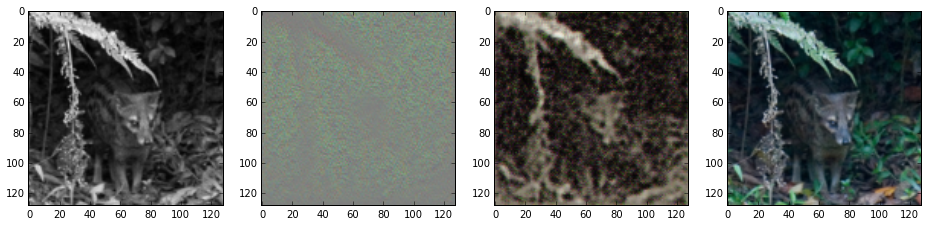

0.0125772298024


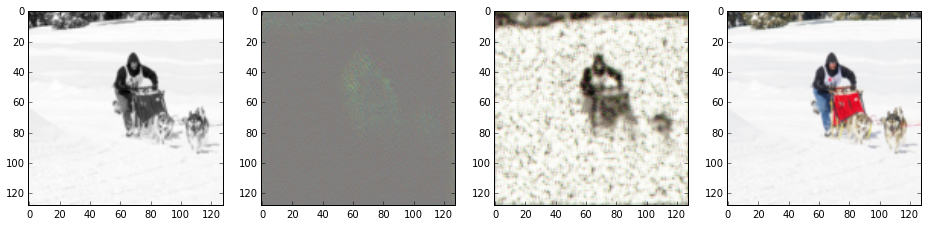

0.0137573865682


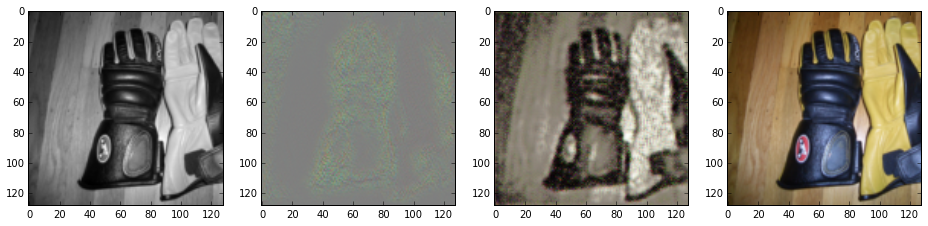

0.00908025190773


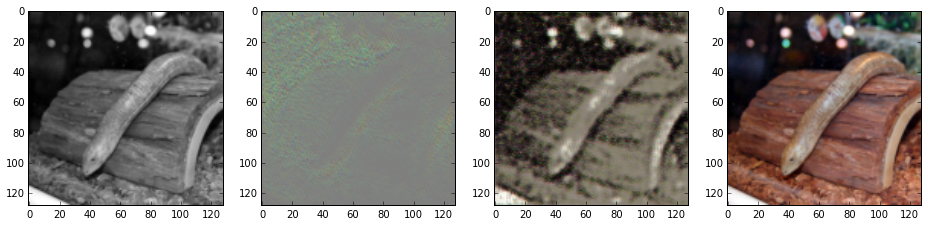

0.0781297993588


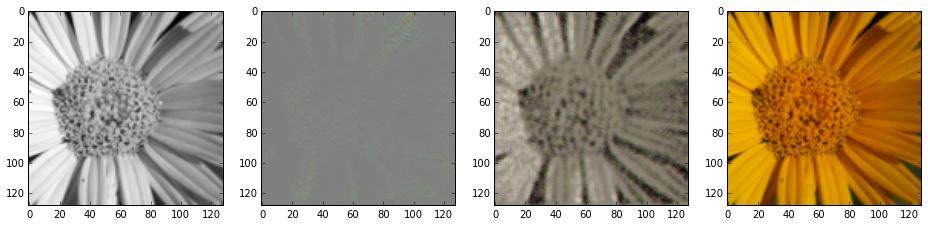

0.00969023187352


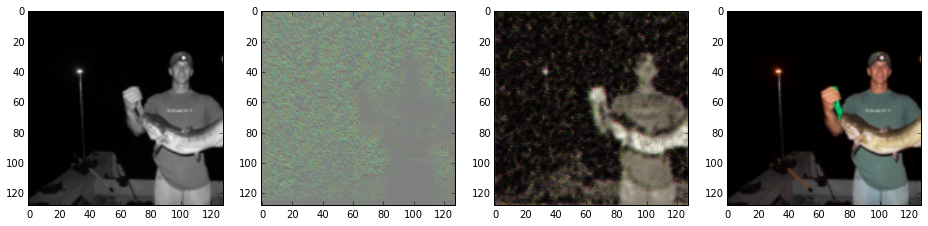

0.0111446194427


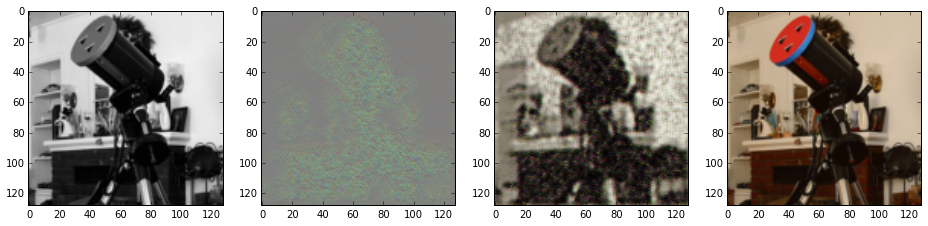

0.0115936331558


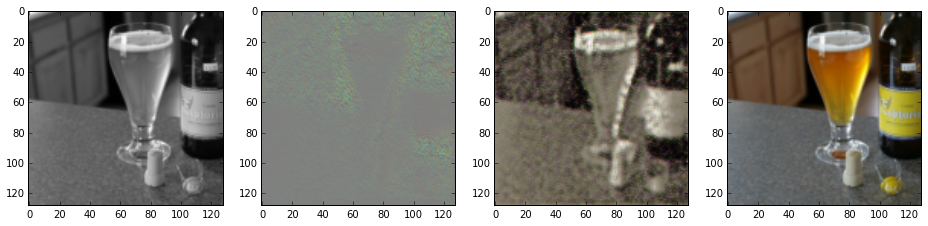

0.0116898275082


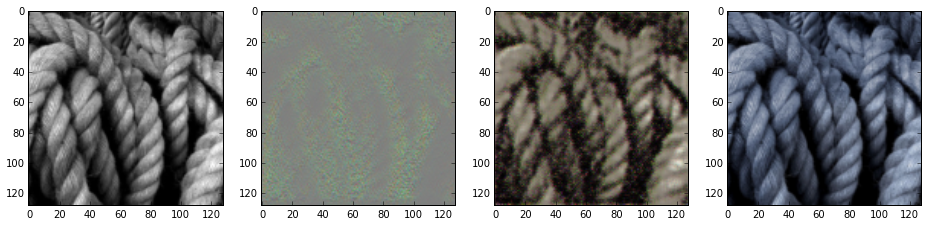

0.0175948670203


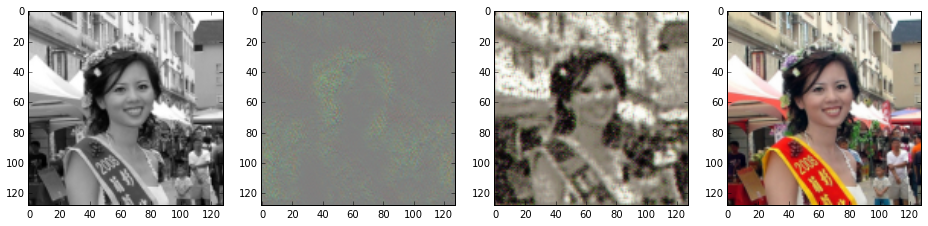

In [208]:
from matplotlib import cm
for x in xrange(30, 40):
    recon, target = [im.reshape((128, 128, 3)) for im in evaluator(images[x])]
    gray = convnets.Grayscale((target * 255).reshape(1, 128, 128, 3)).reshape(128, 128)
    untrained_recon = untrained_evaluator(images[x])[0].reshape((128, 128, 3))
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
    print ((target - recon) ** 2).mean()
    ax3.imshow(target)
    ax2.imshow(recon)
    ax1.imshow(untrained_recon)
    ax0.imshow(gray, cmap=cm.gray)
    plt.show()
    

In [153]:
def GetInputVar(net):
    if hasattr(net, "input_var"):
        return net.input_var
    else:
        return GetInputVar(net.input_layer)

In [155]:
o = lasagne.layers.get_output(net)
i = GetInputVar(net)
apply_net = theano.function([i], o)

In [202]:
apply_net(convnets.Grayscale(images[0].reshape(1, 128, 128, 3)))

array([[-0.02530335,  0.13484843, -0.37182152,  0.10974222,  0.12893638,
         0.05139099]])